# Policy
* 이 노트북 파일은 중간/팀/개인 과제를 재현Reproduce하는 증거로 활용.
    * 따라서, 이 노트북에 기재된 코드를 실행했을 때, Kaggle에 제출한 결과와 일치해야함
    * 무작위성 등으로 인하여 결과가 매번 달라지는 경우에는 Random Seed 등을 설정해서 항상 같은 결과가 나오도록 할 것(예. scikit-learn의 **random_state** 등)
* 다음과 같은 정책을 어길 시 0점 처리되니 유의할 것
    * 노트북에 기재된 코드를 전체 실행했을 때 오류 등으로 실행이 되지 않는 경우
    * 노트북에 명시되지 않은 별도의 코드 및 라이브러리를 사용하는 경우
        * 과제 수행에 필요한 외부 라이브러리 설치 명령은 이 노트북 내에 명시할 것(Installing Libraries 참조)
        * 별도의 Python 파일은 사용하지 말 것. 필요하다면 이 노트북 내에서 구현.
    * 중간 과제에서 제공한 데이터 이외의 별도의 데이터를 사용하는 경우
    * 노트북 파일 내에서 훈련된 모델이 아닌 다른 모델을 사용하는 경우
    * Kaggle 제출 결과와 노트북 파일 실행으로 나온 결과가 크게 다를 경우

# Installing Libraries

아래에 중간 과제를 수행하는 데 필요한 라이브러리 들을 설치하는 명령어를 넣을 것
예를 들어,
```shell
%conda install sklearn
```
또는
```shell
%pip install -U sklearn
```
버전이 중요하다면, 버전도 명확하게 명시할 것
```shell
%conda install sklearn==1.4.2
```
또는
```shell
%pip install sklearn==1.4.2
```

In [7]:
# 설치하는 라이브러리 명시
!pip install -q scikit-learn numpy pandas altair kaggle==1.6.6 graphviz imbalanced-learn
!pip install -q xgboost lightgbm catboost statsmodels plotly optuna tensorflow

In [8]:
import os
from os import path
import json

import glob
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline

import matplotlib.pyplot as plt
import missingno as msno
import plotly.express as px
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from scipy import stats
from scipy.stats import norm, skew
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, balanced_accuracy_score
from sklearn.feature_selection import SelectFromModel
import xgboost as xgb
from xgboost import XGBClassifier
import catboost
from catboost import CatBoostClassifier
import lightgbm as lgbm
from lightgbm import LGBMClassifier
from lightgbm import *
pd.set_option("display.max_columns", None)

import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense,Flatten
from keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings('ignore')

# Data Load
아래에 중간 과제에 활용할 데이터를 불러오는 부분을 넣을 것

## Kaggle에서 데이터 다운로드

In [9]:
USERNAME = "liebenholz" # username
USERKEY = "" # key

In [10]:
json.dump({'username': USERNAME, 'key': USERKEY}, open('kaggle.json', mode='w'))

In [11]:
!mkdir ~/.kaggle/
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c 2024-knu-ml-ind-asmt4
!unzip 2024-knu-ml-ind-asmt4.zip

mkdir: cannot create directory ‘/root/.kaggle/’: File exists
 93% 61.0M/65.6M [00:00<00:00, 224MB/s]
100% 65.6M/65.6M [00:00<00:00, 207MB/s]
Archive:  2024-knu-ml-ind-asmt4.zip
  inflating: sample_submission.csv   
  inflating: test_sensor.csv         
  inflating: train_label.csv         
  inflating: train_sensor.csv        


In [12]:
# pd.read_csv(...)
LABEL = pd.read_csv('./train_label.csv', index_col='id')
SAMPLE = pd.read_csv('./sample_submission.csv', index_col='id')
TRAIN = pd.read_csv('./train_sensor.csv')
TEST = pd.read_csv('./test_sensor.csv')

### Files
- train_sensor.csv: 훈련 센서 데이터
- train_label.csv: 훈련 레이블
- test_sensor.csv: 테스트 센서 데이터
- sample_submission.csv: 제출 예시

### train_sensor.csv 및 test_sensor.csv
train_sensor.csv 및 test_sensor.csv의 필드는 다음과 같다

- X: 가속도계 X축 값; 단위는 1/64 * G = 1/64 * 9.80665 m/s^2
- Y: 가속도계 X축 값; 단위는 1/64 * G = 1/64 * 9.80665 m/s^2
- Z: 가속도계 X축 값; 단위는 1/64 * G = 1/64 * 9.80665 m/s^2
- EDA: 피부전도도(Electrodermal Activity); 단위는 micro siemens
- HR: 심박수(Heart rate); 단위는 beat per minute
-TEMP: 피부 온도; 단위는 섭씨(Celsius degree)
- pid: 피험자의 ID; 8명의 데이터는 train_sensor.csv, 7명의 데이터는 test_sensor.- csv에 존재한다.
- timestamp: 해당 센서값이 수집된 초 단위의 시점; 서로 다른 피험자의 센서 데이터는 최소 7일간 떨어져 있도록 시간을 조정하였다.

### train_label.csv 및 sample_submission.csv
- id: 피험자의 스트레스 값이 측정된 초 단위의 시점; 서로 다른 피험자의 스트레스 측정 시점은 최소 7일간 떨어져 있도록 시간을 조정하였다
- stress: 피험자의 스트레스 강도.
  - 0: 스트레스 받지 않음
  - 1: 중간 정도의 스트레스
  - 2: 심한 스트레스
  

테스트 데이터에 대한 예측 id 및 제출 예시는 sample_submission.csv에 기록되어 있으며, train_label.csv와 동일한 필드 및 의미를 가진다.

## Data Preprocessing, Feature Engineering, and Model Building

이곳부터는 데이터 전처리, 특성값 공학, 모델 훈련 등의 코드를 자유롭게 넣을 것

In [13]:
# Write your code freely

### I. Dataset Exploration

In [14]:
print(LABEL.shape)
LABEL.head()

(3267, 1)


,stress
id,
2617500.0,1.0
2617560.0,1.0
2617620.0,1.0
2617680.0,1.0
2617740.0,1.0


In [15]:
print(SAMPLE.shape)
SAMPLE.head()

(2667, 1)


,stress
id,
17141340.0,-1
11676780.0,-1
1124160.0,-1
24452280.0,-1
20907660.0,-1


In [16]:
print(TRAIN.shape)
TRAIN.head()

(6272640, 8)


,X,Y,Z,EDA,HR,TEMP,pid,timestamp
0,-22.0,-43.0,127.0,21.941885,82.67,36.49,N,2.617440e+06
1,-22.0,-43.0,127.0,21.941885,82.67,36.49,N,2.617440e+06
2,-22.0,-43.0,127.0,21.941885,82.67,36.49,N,2.617440e+06
3,-22.0,-43.0,127.0,21.941885,82.67,36.49,N,2.617440e+06
4,-22.0,-43.0,127.0,21.941885,82.67,36.49,N,2.617440e+06


In [17]:
print(TEST.shape)
TEST.head()

(5120640, 8)


,X,Y,Z,EDA,HR,TEMP,pid,timestamp
0,-31.0,-46.0,8.0,2.567307,77.27,32.65,M,0.00000
1,-34.0,-48.0,5.0,2.567307,77.27,32.65,M,0.03125
2,-39.0,-51.0,0.0,2.567307,77.27,32.65,M,0.06250
3,-44.0,-54.0,-2.0,2.567307,77.27,32.65,M,0.09375
4,-47.0,-56.0,-8.0,2.567307,77.27,32.65,M,0.12500


## II. Data Preparation

### 1. Test 데이터셋 통합

In [18]:
SAMPLE = SAMPLE.reset_index()
SAMPLE

,id,stress
0,17141340.0,-1
1,11676780.0,-1
2,1124160.0,-1
3,24452280.0,-1
4,20907660.0,-1
...,...,...
2662,11611380.0,-1
2663,35273760.0,-1
2664,55981320.0,-1
2665,1239480.0,-1


In [19]:
TEST = TEST.set_index('timestamp').join(
     SAMPLE.set_index('id'), how='outer', rsuffix='_2'
)

TEST

,X,Y,Z,EDA,HR,TEMP,pid,stress
0.000000e+00,-31.0,-46.0,8.0,2.567307,77.27,32.65,M,NaN
3.125000e-02,-34.0,-48.0,5.0,2.567307,77.27,32.65,M,NaN
6.250000e-02,-39.0,-51.0,0.0,2.567307,77.27,32.65,M,NaN
9.375000e-02,-44.0,-54.0,-2.0,2.567307,77.27,32.65,M,NaN
1.250000e-01,-47.0,-56.0,-8.0,2.567307,77.27,32.65,M,NaN
...,...,...,...,...,...,...,...,...
5.607624e+07,-16.0,-56.0,24.0,3.386070,88.37,33.77,E,NaN
5.607624e+07,-8.0,-50.0,27.0,3.386070,88.37,33.77,E,NaN
5.607624e+07,-28.0,-36.0,28.0,3.386070,88.37,33.77,E,NaN
5.607624e+07,-29.0,-29.0,30.0,3.386070,88.37,33.77,E,NaN


In [20]:
unsampled = TEST.drop(['stress'], axis=1)
interpolated = unsampled.interpolate(method='linear')
interpolated

,X,Y,Z,EDA,HR,TEMP,pid
0.000000e+00,-31.0,-46.0,8.0,2.567307,77.27,32.65,M
3.125000e-02,-34.0,-48.0,5.0,2.567307,77.27,32.65,M
6.250000e-02,-39.0,-51.0,0.0,2.567307,77.27,32.65,M
9.375000e-02,-44.0,-54.0,-2.0,2.567307,77.27,32.65,M
1.250000e-01,-47.0,-56.0,-8.0,2.567307,77.27,32.65,M
...,...,...,...,...,...,...,...
5.607624e+07,-16.0,-56.0,24.0,3.386070,88.37,33.77,E
5.607624e+07,-8.0,-50.0,27.0,3.386070,88.37,33.77,E
5.607624e+07,-28.0,-36.0,28.0,3.386070,88.37,33.77,E
5.607624e+07,-29.0,-29.0,30.0,3.386070,88.37,33.77,E


In [21]:
LERP = interpolated.reset_index()
LERP = LERP.set_index('index').join(
    SAMPLE.set_index('id'), how='outer', rsuffix='_2'
)
LERP

,X,Y,Z,EDA,HR,TEMP,pid,stress
0.000000e+00,-31.0,-46.0,8.0,2.567307,77.27,32.65,M,NaN
3.125000e-02,-34.0,-48.0,5.0,2.567307,77.27,32.65,M,NaN
6.250000e-02,-39.0,-51.0,0.0,2.567307,77.27,32.65,M,NaN
9.375000e-02,-44.0,-54.0,-2.0,2.567307,77.27,32.65,M,NaN
1.250000e-01,-47.0,-56.0,-8.0,2.567307,77.27,32.65,M,NaN
...,...,...,...,...,...,...,...,...
5.607624e+07,-16.0,-56.0,24.0,3.386070,88.37,33.77,E,NaN
5.607624e+07,-8.0,-50.0,27.0,3.386070,88.37,33.77,E,NaN
5.607624e+07,-28.0,-36.0,28.0,3.386070,88.37,33.77,E,NaN
5.607624e+07,-29.0,-29.0,30.0,3.386070,88.37,33.77,E,NaN


In [22]:
LERP = LERP.drop(['pid'], axis=1)

for c in LERP.columns:
    print(f'{c}: {len(LERP[c].loc[LERP[c].isnull()])}')

X: 0
Y: 0
Z: 0
EDA: 0
HR: 0
TEMP: 0
stress: 5118091


In [23]:
test = LERP.dropna()
for c in test.columns:
    print(f'{c}: {len(test[c].loc[test[c].isnull()])}')

X: 0
Y: 0
Z: 0
EDA: 0
HR: 0
TEMP: 0
stress: 0


In [24]:
TEST = test.drop(['stress'], axis=1)

In [25]:
TEST

,X,Y,Z,EDA,HR,TEMP
60.0,-75.0,-22.0,-10.0,2.823604,68.92,32.29
120.0,-47.0,-10.0,43.0,4.269208,73.57,32.97
180.0,-53.0,-6.0,37.0,3.352967,79.30,32.21
240.0,-127.0,-7.0,-89.0,5.216015,74.10,32.66
300.0,-45.0,-10.0,45.0,4.286939,72.93,32.65
...,...,...,...,...,...,...
56076000.0,-32.0,22.0,11.0,8.191186,91.17,34.33
56076060.0,-50.0,40.0,-12.0,6.236813,105.55,34.61
56076120.0,-63.0,18.0,-1.0,5.153577,93.32,34.50
56076180.0,-33.0,13.0,51.0,4.429301,81.08,34.13


### 2. TRAIN 데이터셋 통합

In [26]:
LABEL = LABEL.reset_index()

TRAIN = TRAIN.set_index('timestamp').join(
     LABEL.set_index('id'), how='outer', rsuffix='_2'
)

TRAIN

,X,Y,Z,EDA,HR,TEMP,pid,stress
2.617440e+06,-22.0,-43.0,127.0,21.941885,82.67,36.49,N,NaN
2.617440e+06,-22.0,-43.0,127.0,21.941885,82.67,36.49,N,NaN
2.617440e+06,-22.0,-43.0,127.0,21.941885,82.67,36.49,N,NaN
2.617440e+06,-22.0,-43.0,127.0,21.941885,82.67,36.49,N,NaN
2.617440e+06,-22.0,-43.0,127.0,21.941885,82.67,36.49,N,NaN
...,...,...,...,...,...,...,...,...
5.416986e+07,-17.0,-30.0,38.0,0.226755,83.70,31.29,B,NaN
5.416986e+07,-44.0,-44.0,13.0,0.226755,83.70,31.29,B,NaN
5.416986e+07,-52.0,-40.0,6.0,0.226755,83.70,31.29,B,NaN
5.416986e+07,-58.0,-43.0,12.0,0.226755,83.70,31.29,B,NaN


In [27]:
unsampled = TRAIN.drop(['stress'], axis=1)
interpolated = unsampled.interpolate(method='linear')
interpolated

,X,Y,Z,EDA,HR,TEMP,pid
2.617440e+06,-22.0,-43.0,127.0,21.941885,82.67,36.49,N
2.617440e+06,-22.0,-43.0,127.0,21.941885,82.67,36.49,N
2.617440e+06,-22.0,-43.0,127.0,21.941885,82.67,36.49,N
2.617440e+06,-22.0,-43.0,127.0,21.941885,82.67,36.49,N
2.617440e+06,-22.0,-43.0,127.0,21.941885,82.67,36.49,N
...,...,...,...,...,...,...,...
5.416986e+07,-17.0,-30.0,38.0,0.226755,83.70,31.29,B
5.416986e+07,-44.0,-44.0,13.0,0.226755,83.70,31.29,B
5.416986e+07,-52.0,-40.0,6.0,0.226755,83.70,31.29,B
5.416986e+07,-58.0,-43.0,12.0,0.226755,83.70,31.29,B


In [28]:
LERP = interpolated.reset_index()
LERP = LERP.set_index('index').join(
    LABEL.set_index('id'), how='outer', rsuffix='_2'
)
LERP

,X,Y,Z,EDA,HR,TEMP,pid,stress
2.617440e+06,-22.0,-43.0,127.0,21.941885,82.67,36.49,N,NaN
2.617440e+06,-22.0,-43.0,127.0,21.941885,82.67,36.49,N,NaN
2.617440e+06,-22.0,-43.0,127.0,21.941885,82.67,36.49,N,NaN
2.617440e+06,-22.0,-43.0,127.0,21.941885,82.67,36.49,N,NaN
2.617440e+06,-22.0,-43.0,127.0,21.941885,82.67,36.49,N,NaN
...,...,...,...,...,...,...,...,...
5.416986e+07,-17.0,-30.0,38.0,0.226755,83.70,31.29,B,NaN
5.416986e+07,-44.0,-44.0,13.0,0.226755,83.70,31.29,B,NaN
5.416986e+07,-52.0,-40.0,6.0,0.226755,83.70,31.29,B,NaN
5.416986e+07,-58.0,-43.0,12.0,0.226755,83.70,31.29,B,NaN


In [29]:
TRAIN = LERP.dropna()
TRAIN = TRAIN.drop(['pid'], axis=1)
for c in TRAIN.columns:
    print(f'{c}: {len(TRAIN[c].loc[TRAIN[c].isnull()])}')

X: 0
Y: 0
Z: 0
EDA: 0
HR: 0
TEMP: 0
stress: 0


In [30]:
TRAIN

,X,Y,Z,EDA,HR,TEMP,stress
2617500.0,-22.0,-43.0,127.0,21.247677,80.48,36.50,1.0
2617560.0,-22.0,-43.0,127.0,19.742456,87.72,36.50,1.0
2617620.0,-23.0,-43.0,127.0,19.619478,86.50,36.53,1.0
2617680.0,-22.0,-43.0,127.0,20.047886,86.42,36.55,1.0
2617740.0,-22.0,-44.0,127.0,20.490469,88.45,36.55,1.0
...,...,...,...,...,...,...,...
54169560.0,45.0,0.0,43.0,0.224192,106.67,31.79,2.0
54169620.0,44.0,0.0,44.0,0.217787,101.38,31.89,2.0
54169680.0,52.0,-7.0,35.0,0.258782,83.72,32.13,2.0
54169740.0,1.0,-52.0,35.0,0.240847,103.32,31.45,2.0


### 3. 데이터 전처리

array([[<Axes: title={'center': 'X'}>, <Axes: title={'center': 'Y'}>,
        <Axes: title={'center': 'Z'}>],
       [<Axes: title={'center': 'EDA'}>, <Axes: title={'center': 'HR'}>,
        <Axes: title={'center': 'TEMP'}>],
       [<Axes: title={'center': 'stress'}>, <Axes: >, <Axes: >]],
      dtype=object)

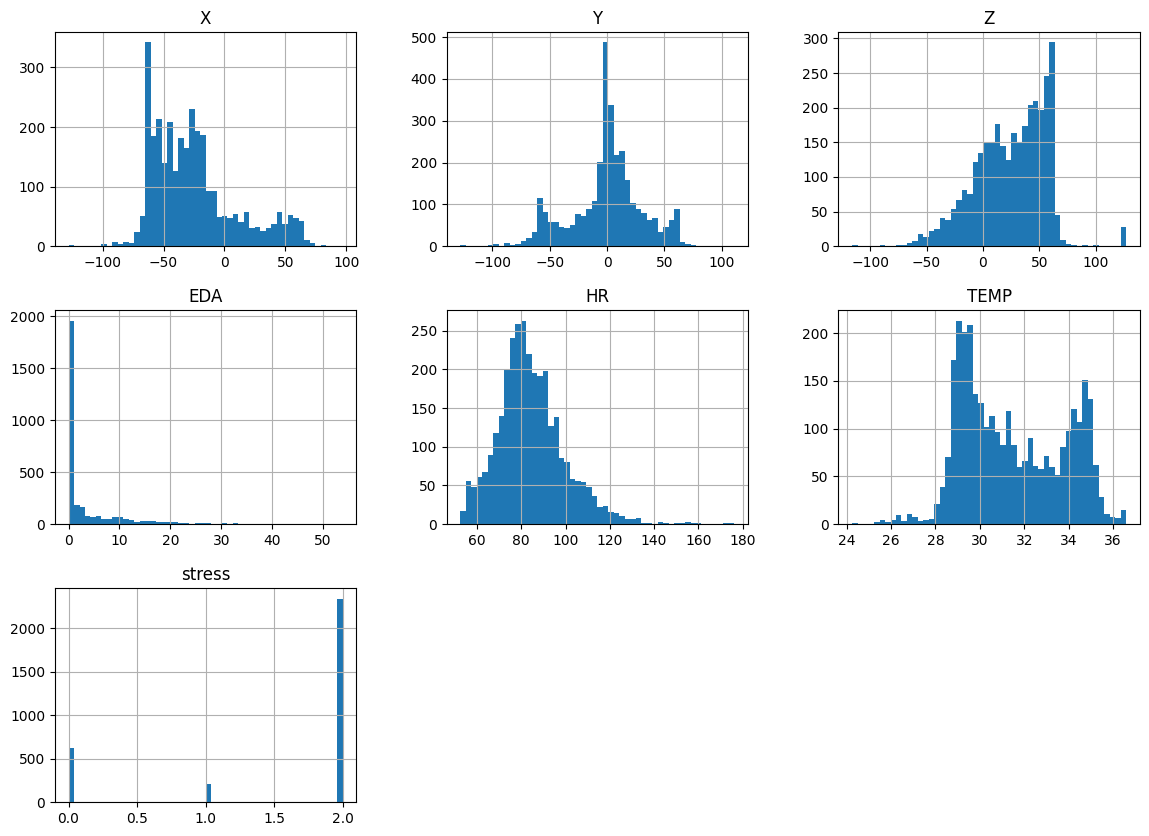

In [31]:
TRAIN.hist(bins = 50, figsize = (14, 10))

In [32]:
TRAIN.describe()

,X,Y,Z,EDA,HR,TEMP,stress
count,3174.000000,3174.000000,3174.000000,3174.000000,3174.000000,3174.000000,3174.000000
mean,-24.990548,-0.115312,25.101449,3.789783,84.471219,31.449890,1.541273
std,35.274958,30.925985,31.102878,6.896113,15.336676,2.302211,0.801058
min,-128.000000,-128.000000,-116.000000,0.000000,52.470000,24.250000,0.000000
25%,-53.000000,-13.000000,3.000000,0.120749,74.705000,29.470000,1.000000
50%,-31.000000,2.000000,29.000000,0.331878,82.525000,31.010000,2.000000
75%,-11.000000,16.000000,51.000000,4.136554,92.437500,33.710000,2.000000
max,97.000000,111.000000,127.000000,53.832458,176.270000,36.590000,2.000000


array([[<Axes: title={'center': 'X'}>, <Axes: title={'center': 'Y'}>,
        <Axes: title={'center': 'Z'}>],
       [<Axes: title={'center': 'EDA'}>, <Axes: title={'center': 'HR'}>,
        <Axes: title={'center': 'TEMP'}>],
       [<Axes: title={'center': 'stress'}>, <Axes: >, <Axes: >]],
      dtype=object)

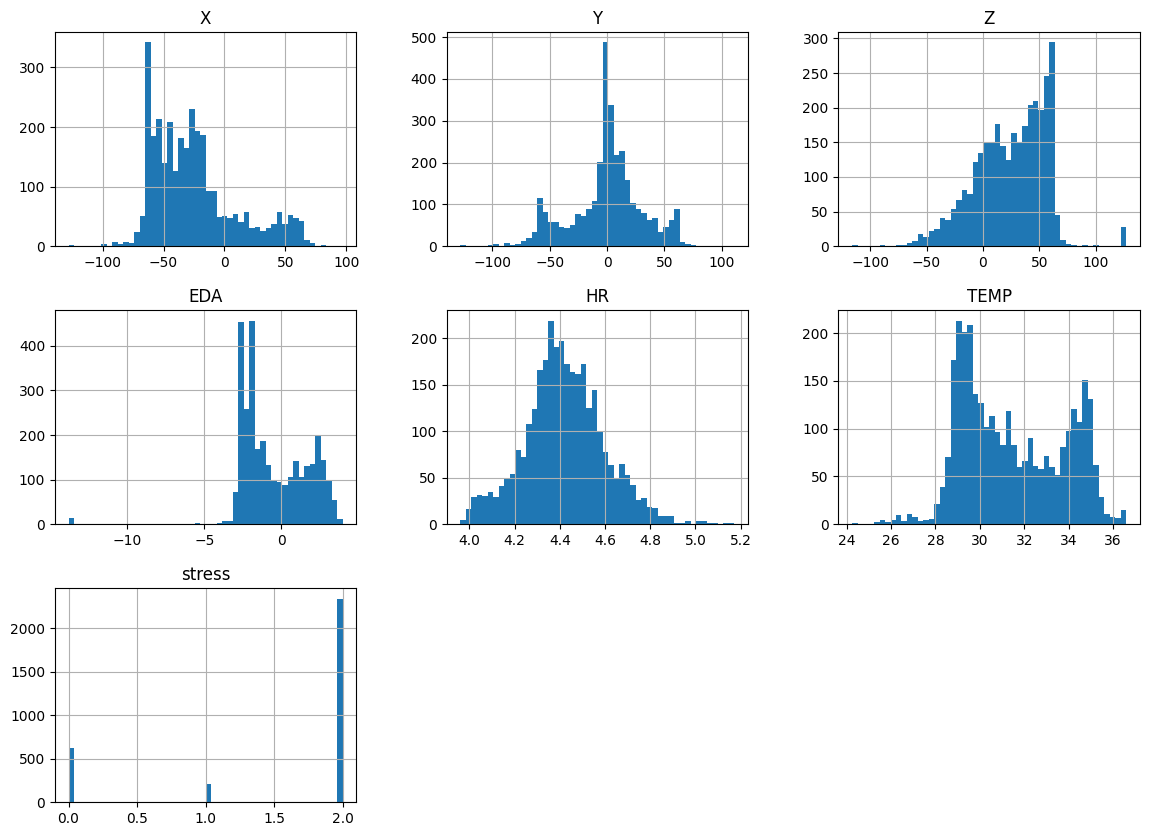

In [33]:
import numpy as np

TRAIN.loc[TRAIN['EDA'] == 0, 'EDA'] = 0.000001

TRAIN_LOG = TRAIN.assign(
    EDA = lambda x: np.log(x['EDA']),
    HR = lambda x: np.log(x['HR'])
)

TRAIN_LOG.hist(bins = 50, figsize = (14, 10))

In [34]:
print("X")
print("Skewness: %f" % TRAIN['X'].skew())
print("Kurtosis: %f" % TRAIN['X'].kurt())

print("Y")
print("Skewness: %f" % TRAIN['Y'].skew())
print("Kurtosis: %f" % TRAIN['Y'].kurt())

print("Z")
print("Skewness: %f" % TRAIN['Z'].skew())
print("Kurtosis: %f" % TRAIN['Z'].kurt())

print("EDA")
print("Skewness: %f" % TRAIN['EDA'].skew())
print("Kurtosis: %f" % TRAIN['EDA'].kurt())

print("HR")
print("Skewness: %f" % TRAIN['HR'].skew())
print("Kurtosis: %f" % TRAIN['HR'].kurt())

print("TEMP")
print("Skewness: %f" % TRAIN['TEMP'].skew())
print("Kurtosis: %f" % TRAIN['TEMP'].kurt())

X
Skewness: 0.931086
Kurtosis: 0.229001
Y
Skewness: -0.349980
Kurtosis: 0.391202
Z
Skewness: -0.307961
Kurtosis: 0.399592
EDA
Skewness: 2.607353
Kurtosis: 7.748388
HR
Skewness: 0.889340
Kurtosis: 2.019149
TEMP
Skewness: 0.231785
Kurtosis: -1.066723


In [35]:
print("EDA Original value")
print("Skewness: %f" % TRAIN['EDA'].skew())
print("Kurtosis: %f" % TRAIN['EDA'].kurt())

EDA Original value
Skewness: 2.607353
Kurtosis: 7.748388


### 4. 특성값 추출

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000518 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1185
[LightGBM] [Info] Number of data points in the train set: 3174, number of used features: 6
[LightGBM] [Info] Start training from score -1.626598
[LightGBM] [Info] Start training from score -2.725210
[LightGBM] [Info] Start training from score -0.303987
LGBMClassifi: 
 [1172 1253 1234 1957 1164 2220]


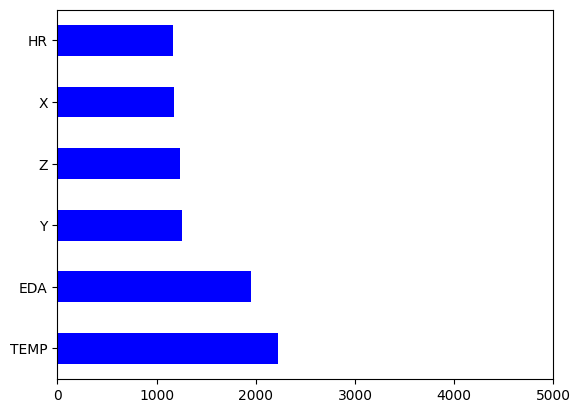

In [36]:
X_data_feature = TRAIN.drop(columns=['stress'],axis=1)
y_data_feature= TRAIN['stress']

model = [LGBMClassifier()]
model = [model[i].fit(X_data_feature,y_data_feature) for i in range(len(model))]

num_chr = [12, 12, 10]

for i in range(len(model)):
    print(str(model[i])[:num_chr[i]] + ': \n',
          model[i].feature_importances_)
    feat_importances = pd.Series(model[i].feature_importances_,
                                 index=X_data_feature.columns)
    feat_importances.nlargest(7).plot(kind='barh', color='blue')
    plt.xlim(0, 5000)
    plt.show()

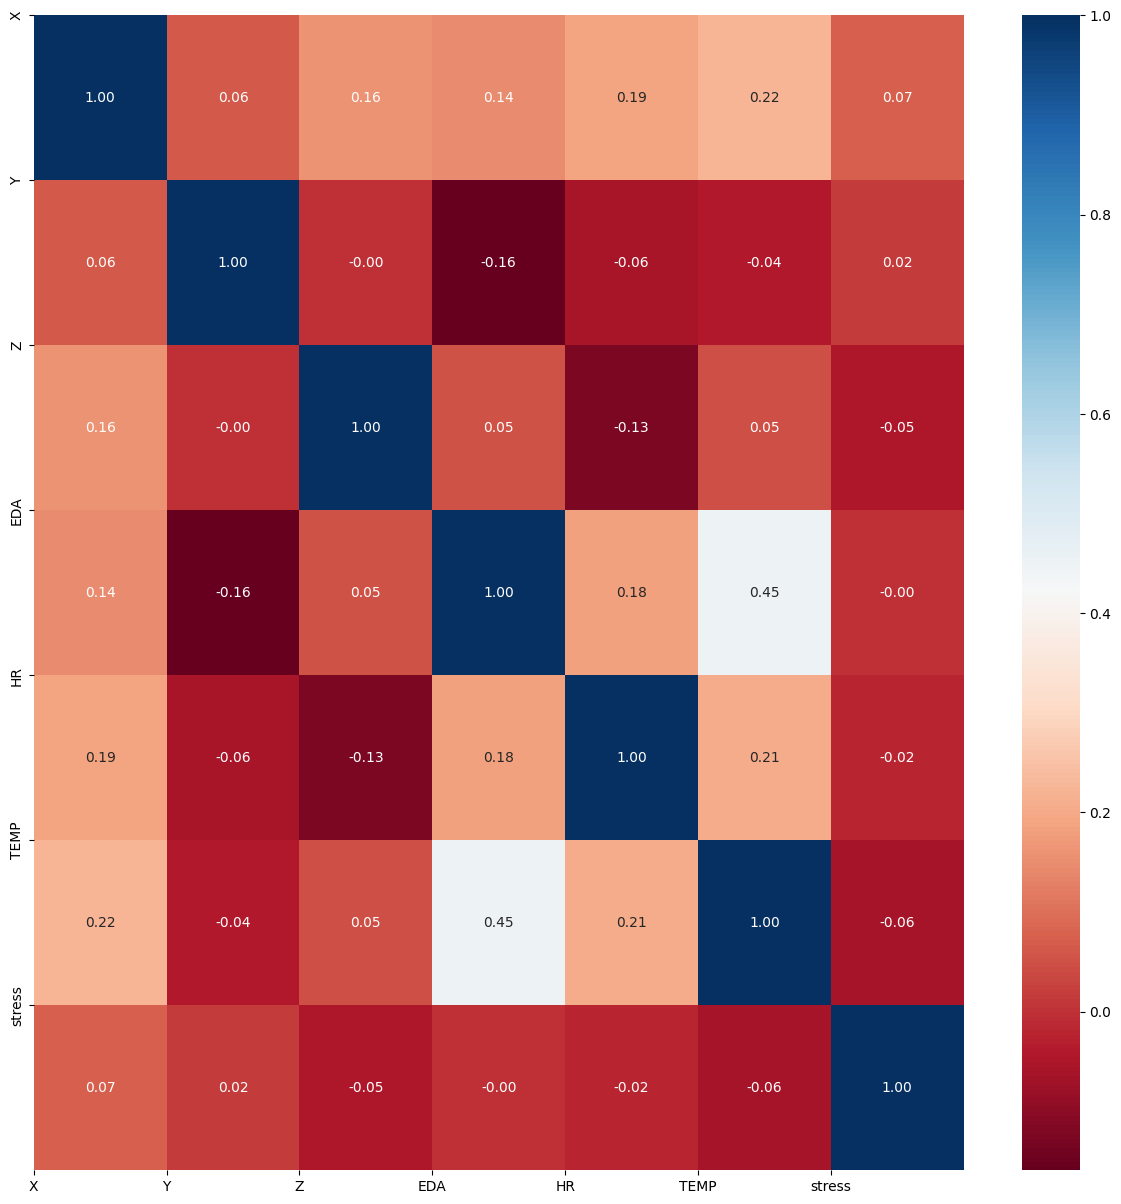

In [37]:
corr = TRAIN.corr(method='pearson')
fig, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(corr, cmap='RdBu', annot=True, fmt=".2f")
plt.xticks(range(len(corr.columns)), corr.columns);
plt.yticks(range(len(corr.columns)), corr.columns)
plt.show()

In [38]:
from sklearn.preprocessing import MinMaxScaler

X = TRAIN.drop(columns=['stress'],axis=1)
y = TRAIN['stress']

X_train = X
y_train = y

MinMaxScaler = MinMaxScaler()
X_train = MinMaxScaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train)
X_train

,0,1,2,3,4,5
0,0.471111,0.355649,1.000000,0.394700,0.226252,0.992707
1,0.471111,0.355649,1.000000,0.366739,0.284733,0.992707
2,0.466667,0.355649,1.000000,0.364454,0.274879,0.995138
3,0.471111,0.355649,1.000000,0.372413,0.274233,0.996759
4,0.471111,0.351464,1.000000,0.380634,0.290630,0.996759
...,...,...,...,...,...,...
3169,0.768889,0.535565,0.654321,0.004165,0.437803,0.611021
3170,0.764444,0.535565,0.658436,0.004046,0.395073,0.619125
3171,0.800000,0.506276,0.621399,0.004807,0.252423,0.638574
3172,0.573333,0.317992,0.621399,0.004474,0.410743,0.583468


In [39]:
X_feat, X_eval, y_feat, y_eval = train_test_split(X_train, y_train,test_size=0.2,random_state=2019)
print("Shape of X_feat: ",X_feat.shape)
print("Shape of X_eval: ", X_eval.shape)
print("Shape of y_feat: ",y_feat.shape)
print("Shape of y_eval",y_eval.shape)

Shape of X_feat:  (2539, 6)
Shape of X_eval:  (635, 6)
Shape of y_feat:  (2539,)
Shape of y_eval (635,)


In [40]:
print(X_feat.shape)
print(X_eval.shape)

(2539, 6)
(635, 6)


### 5. 모델 트레이닝

In [41]:
df = TRAIN.copy()

In [42]:
X, y = df.drop('stress', axis=1), df['stress']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)

In [43]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier


model_lr = LogisticRegression(
    fit_intercept=False
).fit(
    X_feat, y_feat
    # X_train, y_train
)
y_pred = model_lr.predict(X_eval)
print("Logistic Regression:",round(balanced_accuracy_score(y_test,y_pred)*100,6),"%")

model_dt = DecisionTreeClassifier(
    random_state=0
).fit(
    # X_train,y_train
    X_feat, y_feat

)
y_pred = model_dt.predict(X_eval)
print("Decision Tree :",round(balanced_accuracy_score(y_test,y_pred)*100,6),"%")

model_svc1 = SVC(
    C=1.0, probability=True,
    kernel='sigmoid', coef0=1, gamma=0.2
).fit(
    # X_train, y_train
    X_feat, y_feat
)
y_pred = model_svc1.predict(X_eval)
print("SVM1 :",round(balanced_accuracy_score(y_test,y_pred)*100,6),"%")

model_svc2 = SVC(
    C=1.0, probability=True,
    kernel='sigmoid', coef0=10, gamma='scale'
).fit(
    # X_train, y_train
    X_feat, y_feat
)
y_pred = model_svc2.predict(X_eval)
print("SVM2 :",round(balanced_accuracy_score(y_test,y_pred)*100,6),"%")

model_rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=5,
    max_features='sqrt',
    max_samples=0.5,
    random_state=42
).fit(
    # X_train, y_train
    X_feat, y_feat
)
y_pred = model_rf.predict(X_eval)
print("Random Forest :",round(balanced_accuracy_score(y_test,y_pred)*100,6),"%")

model_lgbm = LGBMClassifier(
    objective='multiclass'
).fit(
    # X_train, y_train
    X_feat, y_feat
)
y_pred = model_lgbm.predict(X_eval)
print("Light GBM :",round(balanced_accuracy_score(y_eval,y_pred)*100,6),"%")

model_ab = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=1, random_state=42),
    n_estimators=100,
    learning_rate=1.0,
    random_state=42
).fit(
    # X_train, y_train
    X_feat, y_feat
)
y_pred = model_ab.predict(X_eval)
print("Ada Boost :",round(balanced_accuracy_score(y_eval,y_pred)*100,6),"%")

model_xgb = XGBClassifier(
    objective='multi:softmax',
    n_estimators=100,
    learning_rate=0.1,
    subsample=0.8,
    max_depth=3,
    random_state=42
).fit(
    # X_train, y_train
    X_feat, y_feat
)
y_pred = model_xgb.predict(X_eval)
print("XG Boost :",round(balanced_accuracy_score(y_eval,y_pred)*100,6),"%")

ens1 = VotingClassifier(estimators=[('model_rf', model_rf), ('model_ab', model_ab), ('model_lgbm',model_lgbm), ('model_xgb',model_xgb)], voting='soft')
ens1.fit(X_feat, y_feat)
y_pred = ens1.predict(X_eval)
print("Soft Ensemble :",round(balanced_accuracy_score(y_eval,y_pred)*100,6),"%")

ens2 = VotingClassifier(estimators=[('model_rf', model_rf), ('model_ab', model_ab), ('model_lgbm',model_lgbm), ('model_xgb',model_xgb)], voting='hard')
ens2.fit(X_feat, y_feat)
y_pred = ens2.predict(X_eval)
print("Hard Ensemble :",round(balanced_accuracy_score(y_eval,y_pred)*100,6),"%")


Logistic Regression: 33.262108 %
Decision Tree : 33.990802 %
SVM1 : 33.333333 %
SVM2 : 33.333333 %
Random Forest : 33.899715 %
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000173 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1188
[LightGBM] [Info] Number of data points in the train set: 2539, number of used features: 6
[LightGBM] [Info] Start training from score -1.630936
[LightGBM] [Info] Start training from score -2.674740
[LightGBM] [Info] Start training from score -0.307437
Light GBM : 66.656436 %
Ada Boost : 49.240587 %
XG Boost : 55.142021 %
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000283 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1188
[LightGBM] [Info] Number of data points in the train set: 2539, number of used features: 6
[LightGBM] [Info] Start training from score -1.630936
[LightGBM] [

# Final Model Specification
아래에는 위 전 과정을 거쳐서 최종적으로 선정된 모델을 정의하고 훈련할 것

In [44]:
model = ens1
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print("Bal Acc :",round(balanced_accuracy_score(y_test,y_pred)*100,6),"%")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000174 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1176
[LightGBM] [Info] Number of data points in the train set: 2539, number of used features: 6
[LightGBM] [Info] Start training from score -1.626919
[LightGBM] [Info] Start training from score -2.727538
[LightGBM] [Info] Start training from score -0.303695
Bal Acc : 59.896703 %


In [45]:
import numpy as np
import pandas as pd

y_test_pred = model.predict(TEST)
y_test_pred

array([2., 2., 2., ..., 2., 2., 2.])

In [46]:
SUBMIT = pd.DataFrame({
    'id': SAMPLE.id,
    'label': y_test_pred
})
SUBMIT

,id,label
0,17141340.0,2.0
1,11676780.0,2.0
2,1124160.0,2.0
3,24452280.0,2.0
4,20907660.0,2.0
...,...,...
2662,11611380.0,2.0
2663,35273760.0,2.0
2664,55981320.0,2.0
2665,1239480.0,2.0


# Generate Submission
아래에는 Kaggle에 제출한 결과를 PC에 저장하는 코드를 넣을 것.
노트북 실행 후 아래의 코드를 통해 생성된 결과가 Kaggle에 제출된 결과와 일치해야 함.

In [49]:
# import pandas as pd


# pd.write_csv(...)

In [50]:
sample = pd.read_csv('./sample_submission.csv', index_col='id')

In [51]:
SUBMIT = pd.DataFrame({
    'id': sample.index,
    'label': y_test_pred
})
SUBMIT

,id,label
0,17141340.0,2.0
1,11676780.0,2.0
2,1124160.0,2.0
3,24452280.0,2.0
4,20907660.0,2.0
...,...,...
2662,11611380.0,2.0
2663,35273760.0,2.0
2664,55981320.0,2.0
2665,1239480.0,2.0


In [52]:
SUBMIT["label"].value_counts(normalize=True)

label
2.0    0.692538
0.0    0.298088
1.0    0.009374
Name: proportion, dtype: float64

In [53]:
SUBMIT.to_csv('./submission.csv', index=False)

In [54]:
!kaggle competitions submit --file submission.csv --message "0529.5 : Final Submission" 2024-knu-ml-ind-asmt4

100% 38.8k/38.8k [00:00<00:00, 63.9kB/s]
Successfully submitted to Individual Assignment #4